In [4]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import stanford_mir; stanford_mir.init()

[&larr; Back to Index](index.html)

# Onset Detection

Automatic detection of musical events in an audio signal is one of the most fundamental tasks in music information retrieval. Here, we will show how to detect an **onset**, the very instant that marks the beginning of the transient part of a sound, or the earliest moment at which a transient can be reliably detected.

For more reading:
- [Tutorial on Onset Detection by Juan Bello et al.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.332.989&rep=rep1&type=pdf)
- [Boeck, Sebastian, Florian Krebs, and Markus Schedl. “Evaluating the Online Capabilities of Onset Detection Methods.” ISMIR 2012](http://www.cp.jku.at/research/papers/Boeck_etal_ISMIR_2012.pdf)

## Example - Rock Drum Riff

Load an audio file into the NumPy array `x` and sampling rate `sr`. 

In [5]:
x, sr = librosa.load('audio/classic_rock_beat.wav')
print(x.shape, sr)

(151521,) 22050


Plot the signal:

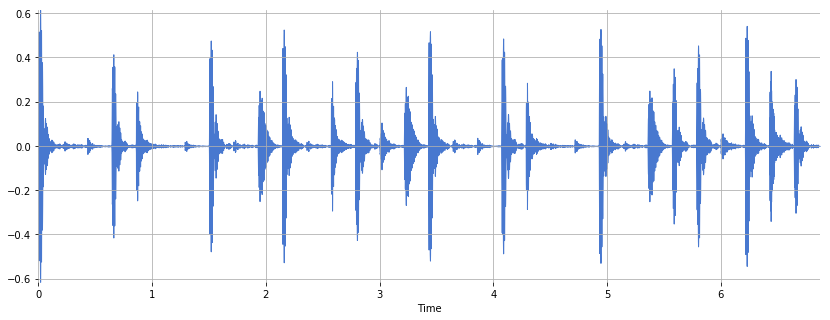

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr)

Listen:

In [7]:
ipd.Audio(x, rate=sr)

## <font color="red"> Exercise 1 </font>

See if you can approximate the timing of the bass drum beats.  Write out your estimates below.

## What is onset detection?

* Determine the start of each new note/chord/beat.
* Usually looks for peaks

## Onset - Attack - Decay

<img src="https://s17-us2.startpage.com/cgi-bin/serveimage?url=https:%2F%2Fi.stack.imgur.com%2FMpxbI.png&sp=f97b268b513ed8e283d2634b9af6f200"/>

## Finding onsets using `librosa.onset.onset_detect`

[`librosa.onset.onset_detect`](http://librosa.github.io/librosa/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect) works in the following way:

1.  Compute a spectral novelty function.
2.  Find peaks in the spectral novelty function.
3.  [optional] Backtrack from each peak to a preceding local minimum. 

## Example - Rock Drum Riff Onsets
Compute the frame indices for estimated onsets in a signal:

In [8]:
onset_frames = librosa.onset.onset_detect(x, sr=sr)
onset_frames # frame numbers of estimated onsets

array([ 20,  29,  38,  57,  66,  75,  84,  93, 103, 112, 121, 131, 140,
       149, 158, 167, 176, 185, 196, 204, 213, 232, 241, 250, 260, 269,
       278, 288])

## Convert onsets to units of seconds

In [9]:
onset_times = librosa.frames_to_time(onset_frames)
onset_times

array([0.46439909, 0.67337868, 0.88235828, 1.32353741, 1.53251701,
       1.7414966 , 1.95047619, 2.15945578, 2.39165533, 2.60063492,
       2.80961451, 3.04181406, 3.25079365, 3.45977324, 3.66875283,
       3.87773243, 4.08671202, 4.29569161, 4.55111111, 4.73687075,
       4.94585034, 5.38702948, 5.59600907, 5.80498866, 6.03718821,
       6.2461678 , 6.45514739, 6.68734694])

Plot the onsets on top of a spectrogram of the audio:

In [43]:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(abs(S))

In [44]:
?librosa.stft

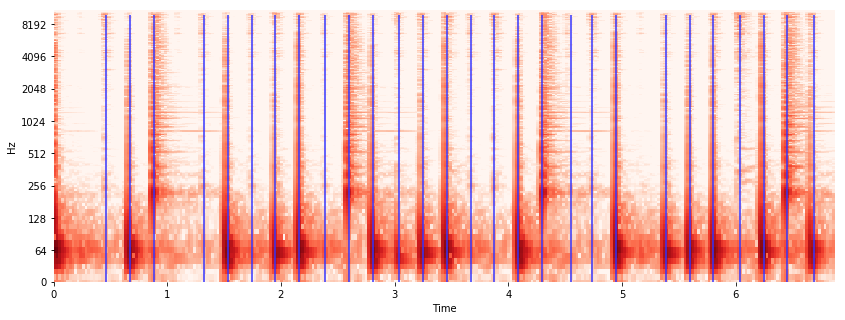

In [45]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log', cmap='Reds')
plt.vlines(onset_times, 0, 10000, color='#3333FF')

Let's also plot the onsets with the time-domain waveform.

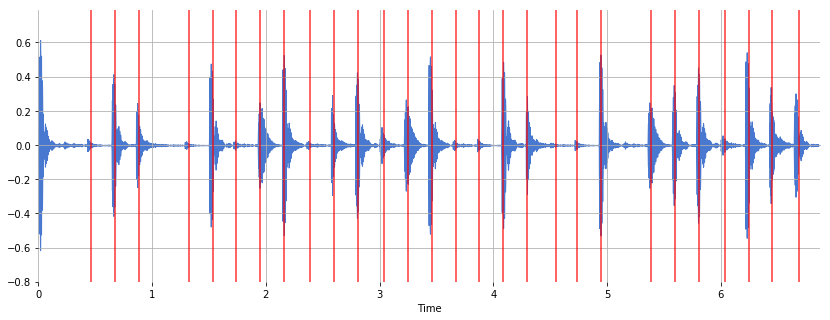

In [46]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.vlines(onset_times, -0.8, 0.79, color='r', alpha=0.8) 

## librosa.clicks

We can add a click at the location of each detected onset.

In [13]:
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(x))

Listen to the original audio plus the detected onsets:

In [14]:
ipd.Audio(x + clicks, rate=sr)

## <font color="red"> Exercise 2 </font>

In `librosa.onset.onset_detect`, use the `backtrack=True` parameter. What does that do, and how does it affect the detected onsets? (See [`librosa.onset.onset_backtrack`](http://librosa.github.io/librosa/generated/librosa.onset.onset_backtrack.html#).)

In `librosa.onset.onset_detect`, you can use the keyword parameters found in [`librosa.util.peak_pick`](http://librosa.github.io/librosa/generated/librosa.util.peak_pick.html#librosa.util.peak_pick), e.g. `pre_max`, `post_max`, `pre_avg`, `post_avg`, `delta`, and `wait`, to control the peak picking algorithm. Adjust these parameters. How does it affect the detected onsets?

Try with other audio files:

In [15]:
ls audio

125_bounce.wav                  latin_groove.mp3
58bpm.wav                       noisy_tone.wav
README.md                       oboe_c6.wav
brahms_hungarian_dance_5.mp3    prelude_cmaj.wav
busta_rhymes_hits_for_days.mp3  simple_loop.wav
c_strum.wav                     simple_piano.wav
clarinet_c6.wav                 sir_duke_piano_fast.mp3
classic_rock_beat.mp3           sir_duke_piano_slow.mp3
classic_rock_beat.wav           sir_duke_trumpet_fast.mp3
conga_groove.wav                sir_duke_trumpet_slow.mp3
drum_samples/                   thx_original.mp3
funk_groove.mp3                 tone_440.wav
jangle_pop.mp3                  yanni-laurel.wav


# Onset-based Segmentation with Backtracking

[`librosa.onset.onset_detect`](http://librosa.github.io/librosa/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect) works by finding peaks in a spectral novelty function. However, these peaks may not actually coincide with the initial rise in energy or how we perceive the beginning of a musical note.

The optional keyword parameter `backtrack=True` will backtrack from each peak to a preceding local minimum. Backtracking can be useful for finding segmentation points such that the onset occurs shortly after the beginning of the segment. We will use `backtrack=True` to perform onset-based segmentation of a signal.

Load an audio file into the NumPy array `x` and sampling rate `sr`. 

## Onset - Attack - Decay

<img src="https://s17-us2.startpage.com/cgi-bin/serveimage?url=https:%2F%2Fi.stack.imgur.com%2FMpxbI.png&sp=f97b268b513ed8e283d2634b9af6f200"/>

In [16]:
hop_length = 512
onset_frames = librosa.onset.onset_detect(x, sr=sr, hop_length=hop_length)
onset_frames # frame numbers of estimated onsets

array([ 20,  29,  38,  57,  66,  75,  84,  93, 103, 112, 121, 131, 140,
       149, 158, 167, 176, 185, 196, 204, 213, 232, 241, 250, 260, 269,
       278, 288])

Convert onsets to units of seconds:

In [17]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
onset_times

array([0.46439909, 0.67337868, 0.88235828, 1.32353741, 1.53251701,
       1.7414966 , 1.95047619, 2.15945578, 2.39165533, 2.60063492,
       2.80961451, 3.04181406, 3.25079365, 3.45977324, 3.66875283,
       3.87773243, 4.08671202, 4.29569161, 4.55111111, 4.73687075,
       4.94585034, 5.38702948, 5.59600907, 5.80498866, 6.03718821,
       6.2461678 , 6.45514739, 6.68734694])

Convert onsets to units of samples:

In [18]:
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)
onset_samples

array([ 10240,  14848,  19456,  29184,  33792,  38400,  43008,  47616,
        52736,  57344,  61952,  67072,  71680,  76288,  80896,  85504,
        90112,  94720, 100352, 104448, 109056, 118784, 123392, 128000,
       133120, 137728, 142336, 147456])

Plot the onsets on top of a spectrogram of the audio:

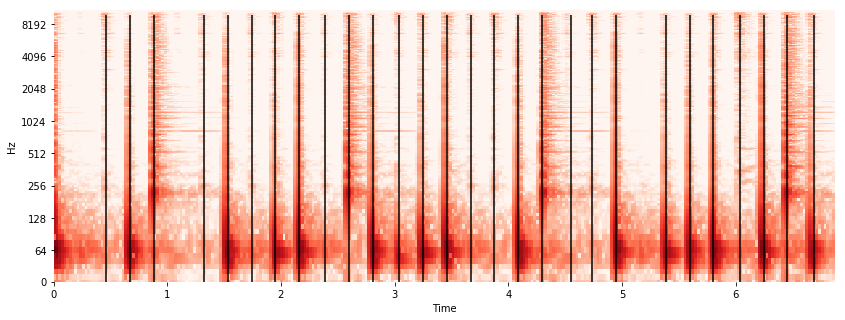

In [21]:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(np.abs(S))


plt.figure(figsize=(14, 5))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log', cmap = "Reds")
plt.vlines(onset_times, 0, 10000, color='k')

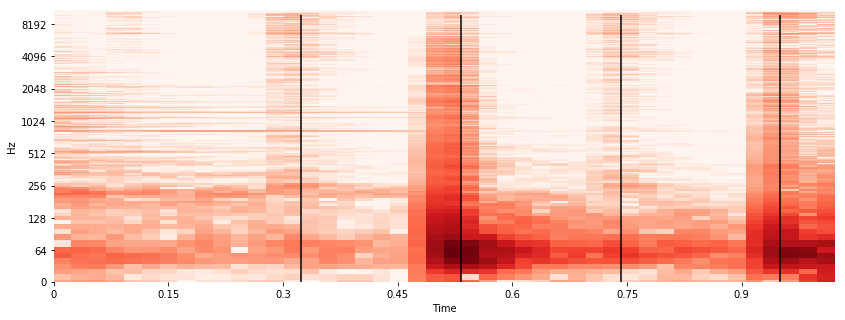

In [36]:
times = np.array(range(len(x)))/sr
time_window = np.logical_and(times > 1, times < 2)
S = librosa.stft(x[time_window])
logS = librosa.amplitude_to_db(np.abs(S))
onset_times_windowed = np.logical_and(onset_times > 1, onset_times < 2)
plt.figure(figsize=(14, 5))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log', cmap = "Reds")
plt.vlines(onset_times[onset_times_windowed] - 1, 0, 10000, color='k')

As we see in the spectrogram, the detected onsets seem to occur a bit before the actual rise in energy.

Let's listen to these segments. We will create a function to do the following:

1.  Divide the signal into segments beginning at each detected onset.
2.  Pad each segment with 500 ms of silence.
3.  Concatenate the padded segments.

In [56]:
def concatenate_segments(x, onset_samples, pad_duration=0.500):
    """Concatenate segments into one signal."""
    silence = numpy.zeros(int(pad_duration*sr)) # silence
    frame_sz = min(numpy.diff(onset_samples))   # every segment has uniform frame size
    return numpy.concatenate([
        numpy.concatenate([x[i:i+frame_sz], silence]) # pad segment with silence
        for i in onset_samples
    ])

In [57]:
concatenated_signal = concatenate_segments(x, onset_samples, 0.500)

Concatenate the segments:

concatenated_signal = concatenate_segments(x, onset_samples, 0.500)

Listen to the concatenated signal:

In [58]:
ipd.Audio(concatenated_signal, rate=sr)

As we hear, the little glitch between segments occurs because the segment boundaries occur during the attack, not before the attack.

## `librosa.onset.onset_backtrack`

We can avoid this glitch by backtracking from the detected onsets. 

When setting the parameter `backtrack=True`, `librosa.onset.onset_detect` will call [`librosa.onset.onset_backtrack`](http://librosa.github.io/librosa/generated/librosa.onset.onset_backtrack.html).
 For each detected onset, `librosa.onset.onset_backtrack` searches backward for a local minimum.

In [59]:
onset_frames = librosa.onset.onset_detect(x, sr=sr, hop_length=hop_length, backtrack=True)

Convert onsets to units of seconds:

In [60]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)

Convert onsets to units of samples:

In [61]:
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)

Plot the onsets on top of a spectrogram of the audio:

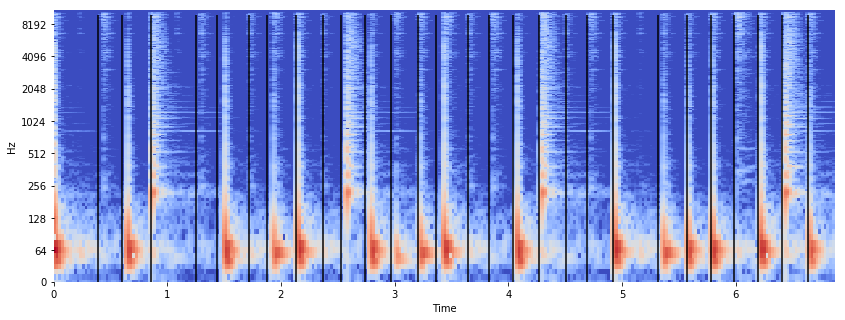

In [62]:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(np.abs(S))
plt.figure(figsize=(14, 5))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='k')

Notice how the vertical lines denoting each segment boundary appears before each rise in energy.

Concatenate the segments:

In [63]:
concatenated_signal = concatenate_segments(x, onset_samples, 0.500)

Listen to the concatenated signal:

In [64]:
ipd.Audio(concatenated_signal, rate=sr)

While listening, notice now the segments are perfectly segmented.

## Top Hat

The first segment is an example of a top-hat.

In [78]:
i = 0
ipd.Audio(x[onset_samples[i]:onset_samples[i + 1]], rate=sr)

## Bass Drum

The second segment is a bass drum.

In [79]:
i = 1
ipd.Audio(x[onset_samples[i]:onset_samples[i + 1]], rate=sr)

## Snare Drum

The third is a snare drum.

In [80]:
i = 2
ipd.Audio(x[onset_samples[i]:onset_samples[i + 1]], rate=sr)

## <font color="red"> Exercise 2 </font>

For each instrument, make the following plots.

* Plot the segment in the time domain.
* Plot the segment in the frequency domain.
* Make a spectrogram of the segment. 

## <font color="red"> Exercise 3 </font>

Listen to and classify each segment.

In [81]:
num_segment = len(onset_samples)
num_segment

28

In [82]:
i = 3
cls = ["Top Hat", 
       "Bass Drum", 
       "Snare Drum", 
       ...]
ipd.Audio(x[onset_samples[i]:onset_samples[i + 1]], rate=sr)

## <font color="red"> Exercise 4 </font>

Inspect the spectrogram shown below while listening to the track.  Is there useful information that might determine the type instrument used in each segment? How might you build features to classify the each segments as *Bass Drum*, *Snare*, *Cymbal*, etc.?

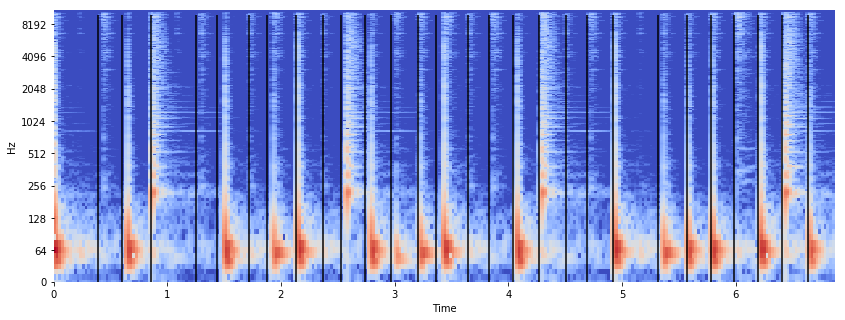

In [77]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='k')

In [83]:
ipd.Audio(concatenated_signal, rate=sr)

## <font color="red"> Exercise 5</font>

Try with other audio files:

In [84]:
ls audio

125_bounce.wav                  latin_groove.mp3
58bpm.wav                       noisy_tone.wav
README.md                       oboe_c6.wav
brahms_hungarian_dance_5.mp3    prelude_cmaj.wav
busta_rhymes_hits_for_days.mp3  simple_loop.wav
c_strum.wav                     simple_piano.wav
clarinet_c6.wav                 sir_duke_piano_fast.mp3
classic_rock_beat.mp3           sir_duke_piano_slow.mp3
classic_rock_beat.wav           sir_duke_trumpet_fast.mp3
conga_groove.wav                sir_duke_trumpet_slow.mp3
drum_samples/                   thx_original.mp3
funk_groove.mp3                 tone_440.wav
jangle_pop.mp3                  yanni-laurel.wav


[&larr; Back to Index](index.html)